>## BING 6004: Principles of Computational Bioengineering
>### Assignment 3 - Motif Discovery – Spring 2022
>### Due Date: May 9, 2022
>> ***Summary and electronic files should be submitted through online.upr.edu***

<p dir="ltr" style="text-align: left;"></p>
<p><strong>General Instructions</strong><br></p>
<ol>
    <li>Write a cover page with the following format:&nbsp;</li>
    <p></p>
        <p style="text-align: center;">MIDTERM I BING 6004 - Second Semester 2021-2022</p>
        <p style="text-align: center;">Full name&nbsp;</span></p>
        <p style="text-align: center;">Student ID Do not add logos or any additional information.</p>
        <li> Name each file with _NameLastName</li>
</ol>

>### Prologue
The SAMPLE2.fasta file is a nucleotide sequence believed to contain a motif of size 15. The task is to use a multiple alignment method to find the motifs. An additional 500 bps sequence is given, and you are requested to ask whether there is one or more 15-bps segment(s) in the sequence, which is(are) a potential member of the motif. Your findings, if any, should be supported by significance analysis using the p-value. To do this, you are asked to perform the following calculations.

<p style="text-align:center;">
<img src="figures/mview.svg" alt="NCBI_database" class="center"/>
</p>

In [2]:
import re
import copy
from Bio import SeqIO

class MsView():
    def __init__(self, fasta_file, plot_width=80):
        self.fasta_file = fasta_file
        self.plot_width = plot_width
        self._bg = None
        self.records = None
        self.from_file()
        
    def from_file(self, fasta_file=None, frm = 'fasta'):
        if fasta_file is not None:
            self.fasta_file = fasta_file
        with open(self.fasta_file) as handle:
            self.records = [record for record in SeqIO.parse(handle, frm)]
            self._alignment_length = max([len(record.seq) for record in self.records])
        self.set_bg()
    
    def set_bg(self):
        bg_c = {
            'A': 10,
            'C': 11,
            'G': 12,
            'T': 9,
            'U': 9
        }
        self._bg = []
        for seq in self.records:
            self._bg.append([bg_c.get(n, 255) for n in seq.seq])
            
    def to_str(self, pattern=''):
        tmp_str = []
        bg_copy = copy.deepcopy(self._bg)
        try:
            regex = re.compile(pattern, re.I)
        except:
            regex = re.compile('', re.I)
        for i, seq in enumerate(self.records):
            for m in regex.finditer(str(seq.seq)):
                for j in range(m.start(),m.end()):
                    bg_copy[i][j] = 245
                    
        num_blks = self._alignment_length // self.plot_width + 1
        for i_b in range(num_blks):
            b_start = i_b*self.plot_width
            b_end = (i_b + 1)*self.plot_width
            tmp_str.append("{:03d}{}{:03d}\n".format(b_start, (self.plot_width-6)*'.', b_end))
            for seq, bgs in zip(self.records, bg_copy):
                for n, bg in zip(seq[b_start: b_end], bgs[b_start: b_end]):
                    tmp_str.append(f"\033[48;5;{bg}m{n}")
                tmp_str.append("\033[0;0m\n")
            tmp_str.append("\n")
        return "".join(tmp_str)
    
    def view(self, pattern=''):
        print(self.to_str(pattern))

    def __str__(self):
        return self.to_str()

In [5]:
from ipywidgets import interact, widgets
from IPython.display import display

fas = widgets.Text(
    value='../data/SAMPLE2.fasta',
    placeholder='Fasta file',
    description='File:',
    disabled=False
)

pattern = widgets.Text(
    value='(A|C|T)(A|T)G(C|G|T)(A|C)(C|G|A)(A|T)(A|C|G)(A|G)C(A|T)(A|G|T)(C|G)(C|T)(A|C|T)',
    placeholder='Pattern to search',
    description='Pattern:',
    disabled=False
)

msview = MsView(fas.value)
out = widgets.interactive_output(msview.view, {'pattern': pattern})
widgets.VBox([widgets.VBox([fas, pattern]), out])

### 2. Use Bio.motifs module and re-module to calculate:

2. a) Consensus and Anticonsensus.

In [7]:
from Bio import motifs
from Bio.Seq import Seq

instances = [Seq("ATGCCCAGACATGCC"),
Seq("ATGCCCAGACATGCC"),
Seq("ATGCCCAGACATGCT"),
Seq("ATGCCCAGACATGCC"),
Seq("ATGTCCAGGCATGCC"),
Seq("ATGTCCAGGCATGCA"),
Seq("ATGTAGTCACTTGTT"),
Seq("TTGTCCTAACATGTT"),
Seq("AAGCCAAGACATGCT"),
Seq("CTGTCCAGGCATGCA"),
Seq("ATGTCCAGGCAGCTT"),
Seq("CTGGAGAGGCAAGCC"),
Seq("TAGTCCAGACAAGTC"),
Seq("ATGTCAAGACTTGTC"),
Seq("ATGCCCACACAAGCC")]

m = motifs.create(instances)
print(f"Motif length : {len(m)}")
print(f"Motif consensus: {m.consensus}")
print(f"Motif anti-consensus: {m.anticonsensus}")

Motif length : 15
Motif consensus: ATGTCCAGACATGCC
Motif anti-consensus: GCAAGTCTCACCAAG


2. b)	PSSM and PFM Matrices.

In [9]:
import pandas as pd

print('PFM matrix:')
pd.DataFrame.from_dict(dict(m.counts)).T

PFM matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,11,2,0,0,2,2,13,1,10,0,13,3,0,0,2
C,2,0,0,6,13,11,0,2,0,15,0,0,1,10,8
G,0,0,15,1,0,2,0,12,5,0,0,1,14,0,0
T,2,13,0,8,0,0,2,0,0,0,2,11,0,5,5


In [10]:
from collections import Counter

def nucleotide_frequency(seq):
    return dict(Counter(seq))

ppm = m.counts.normalize()

In [12]:
from Bio import SeqIO

with open('../data/500bp.fasta') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        seq_500 = record.seq

background = nucleotide_frequency(seq_500)
total = sum(background.values())
values = {}
alphabet = m.alphabet
for letter in alphabet:
    background[letter] /= total
    values[letter] = []

In [13]:
import math

for i in range(m.length):
    for letter in alphabet:
        b = background[letter]
        if b > 0:
            p = ppm[letter][i]
            logodds = math.log(p + (p+1.0) / b, 2)
        else:
            p = self[letter][i]
            if p > 0:
                logodds = math.inf
            else:
                logodds = math.nan
        values[letter].append(logodds)

In [15]:
pssm = motifs.matrix.PositionSpecificScoringMatrix(alphabet, values)
df_pssm = pd.DataFrame.from_dict(dict(pssm)).T
print('PSSM matrix:')
df_pssm.applymap("{0:.2f}".format)

PSSM matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,2.83,2.11,1.88,1.88,2.11,2.11,2.96,2.00,2.77,1.88,2.96,2.21,1.88,1.88,2.11
C,2.34,2.13,2.13,2.70,3.17,3.05,2.13,2.34,2.13,3.28,2.13,2.13,2.24,2.99,2.85
G,2.14,2.14,3.29,2.25,2.14,2.36,2.14,3.13,2.63,2.14,2.14,2.25,3.24,2.14,2.14
T,2.10,2.95,1.87,2.62,1.87,1.87,2.10,1.87,1.87,1.87,2.10,2.82,1.87,2.38,2.38


### 3. Slide a 15-bps windows over the 500 bp sequence on 500bp.fasta file

3. a)	Construct a histogram with the scores of the windows 

In [16]:
max_score = df_pssm.max(numeric_only=True).sum()
min_score = df_pssm.min(numeric_only=True).sum()

In [17]:
def relative_score(seq, pssm, min_score=0.0, max_score=1.0):
    if sorted(pssm.alphabet) != ["A", "C", "G", "T"]:
        raise ValueError(
            "PSSM has wrong alphabet: %s - Use only with DNA motifs" % pssm.alphabet
        )
    if len(seq) > pssm.length:
        raise ValueError(
            "Seq is too big " % len(seq)
        )
    score = 0
    for i, n in enumerate(seq):
        score += pssm[n, i]
    return (score-min_score)/(max_score-min_score)

In [19]:
# Sliding window
# seq_500[k:k+15]

import numpy as np
rs = []
for k in range(len(seq_500) - 15 +1):
    rs.append(relative_score(seq_500[k:k+15], pssm, min_score, max_score))
rs = np.array(rs)

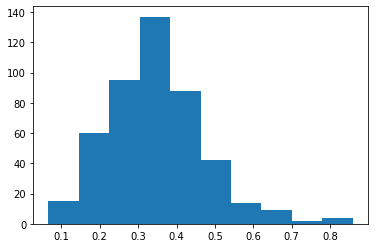

In [20]:
#histogram
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# getting data of the histogram
counts, bins_counts = np.histogram(rs)
plt.stairs(counts, bins_counts, fill=True)

3. b)	Compute the p-value and find the segment(s) whose score rejects the null-hypothesis: “the sequence does not belong to the motif”.

In [21]:
def empirical_pvalue(array, val):
    return float(len(array[array > val]))/float(len(array))

epv = np.array([empirical_pvalue(rs, s) for s in rs])

In [22]:
epv[epv < 0.05]

array([0.03433476, 0.01287554, 0.03862661, 0.00214592, 0.027897  ,
       0.02145923, 0.01716738, 0.03218884, 0.01502146, 0.03004292,
       0.00643777, 0.03648069, 0.        , 0.02360515, 0.02575107,
       0.0193133 , 0.01072961, 0.04291845, 0.00429185, 0.0472103 ,
       0.04506438, 0.00858369, 0.04077253, 0.04935622])